In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10055573900742648227
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 3482287899285544957
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 5350588285369057355
physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10977044071
locality {
  bus_id: 1
}
incarnation: 12161024362522557317
physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 10975051776
locality {
  bus_id: 1
}
incarnation: 9133606906835468453
physical_device_desc: "device: 3, name: Ge

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [5]:
cd /media/datastorage/Phong/fashion_mnist

/media/datastorage/Phong/fashion_mnist


In [1]:
## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)


Using TensorFlow backend.


In [2]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

In [3]:
#SET 1

from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, Reshape, Concatenate,Bidirectional
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f2_base = senet(input_shape=(299,299,3), weights='imagenet', include_top=False)
f2_x = GlobalAveragePooling2D()(f2_base.output)

f2_x = Reshape([1,2048])(f2_x)  
f2_x = Bidirectional(LSTM(1024, 
                                 return_sequences=False, 
#                                  dropout=0.8
                                ),
                            input_shape=[1,2048],
                            merge_mode='concat')(f2_x)

# # #Regularization with noise
f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(10, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# # print(f2_base.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

lambda_293 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
lambda_294 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
lambda_295 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
lambda_296 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv2d_294 (Conv2D)             (None, 19, 19, 16)   2304        lambda_265[0][0]                 
__________________________________________________________________________________________________
conv2d_295

conv2d_539 (Conv2D)             (None, 19, 19, 16)   2304        lambda_492[0][0]                 
__________________________________________________________________________________________________
conv2d_540 (Conv2D)             (None, 19, 19, 16)   2304        lambda_493[0][0]                 
__________________________________________________________________________________________________
conv2d_541 (Conv2D)             (None, 19, 19, 16)   2304        lambda_494[0][0]                 
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 19, 19, 512)  0           conv2d_510[0][0]                 
                                                                 conv2d_511[0][0]                 
                                                                 conv2d_512[0][0]                 
                                                                 conv2d_513[0][0]                 
          

__________________________________________________________________________________________________
conv2d_831 (Conv2D)             (None, 1, 1, 64)     65600       lambda_759[0][0]                 
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 1, 1, 64)     0           conv2d_831[0][0]                 
__________________________________________________________________________________________________
conv2d_832 (Conv2D)             (None, 1, 1, 1024)   66560       activation_114[0][0]             
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 1, 1, 1024)   0           conv2d_832[0][0]                 
__________________________________________________________________________________________________
multiply_23 (Multiply)          (None, 19, 19, 1024) 0           batch_normalization_73[0][0]     
          

conv2d_1184 (Conv2D)            (None, 10, 10, 32)   9216        lambda_1082[0][0]                
__________________________________________________________________________________________________
conv2d_1185 (Conv2D)            (None, 10, 10, 32)   9216        lambda_1083[0][0]                
__________________________________________________________________________________________________
conv2d_1186 (Conv2D)            (None, 10, 10, 32)   9216        lambda_1084[0][0]                
__________________________________________________________________________________________________
conv2d_1187 (Conv2D)            (None, 10, 10, 32)   9216        lambda_1085[0][0]                
__________________________________________________________________________________________________
conv2d_1188 (Conv2D)            (None, 10, 10, 32)   9216        lambda_1086[0][0]                
__________________________________________________________________________________________________
conv2d_118

In [13]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 3
batch_size = 30
#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/40
1999/2000 [============================>.] - ETA: 0s - loss: 0.3357 - acc: 0.8793
Saving val_acc 0.917700 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM.pkl
2000/2000 [==============================] - 2073s 1s/step - loss: 0.3358 - acc: 0.8793 - val_loss: 0.2408 - val_acc: 0.9177
Epoch 2/40
1999/2000 [============================>.] - ETA: 0s - loss: 0.2877 - acc: 0.8952
Saving val_acc 0.917700 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM.pkl
2000/2000 [==============================] - 1998s 999ms/step - loss: 0.2877 - acc: 0.8952 - val_loss: 0.2187 - val_acc: 0.9177
Epoch 3/40
1999/2000 [============================>.] - ETA: 0s - loss: 0.2608 - acc: 0.9056
Saving val_acc 0.926400 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM.pkl
2000/2000 [==============================] - 2013s 1s/step - loss: 0.2609 - acc: 0.9055 - val_loss: 0.2114 - val_acc: 0.9264


In [ ]:
mkdir checkpoints

In [9]:
# Change LR=1e-5

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 3
batch_size = 30

epochs = 10##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L2.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9772
Saving val_acc 0.953400 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L2.pkl
2000/2000 [==============================] - 2031s 1s/step - loss: 0.0627 - acc: 0.9772 - val_loss: 0.1840 - val_acc: 0.9534
Epoch 2/10
2000/2000 [==============================] - 1960s 980ms/step - loss: 0.0507 - acc: 0.9812 - val_loss: 0.2037 - val_acc: 0.9528
Epoch 3/10
2000/2000 [==============================] - 1975s 987ms/step - loss: 0.0471 - acc: 0.9826 - val_loss: 0.2048 - val_acc: 0.9533
Epoch 4/10
2000/2000 [==============================] - 1958s 979ms/step - loss: 0.0457 - acc: 0.9830 - val_loss: 0.2154 - val_acc: 0.9521
Epoch 5/10
2000/2000 [==============================] - 1988s 994ms/step - loss: 0.0442 - acc: 0.9842 - val_loss: 0.2156 - val_acc: 0.9517
Epoch 6/10
2000/2000 [============================

In [11]:
max(result.history['val_acc']),min(result.history['val_acc'])

(0.9538999910354614, 0.9516999927759171)

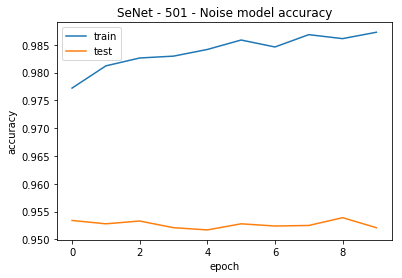

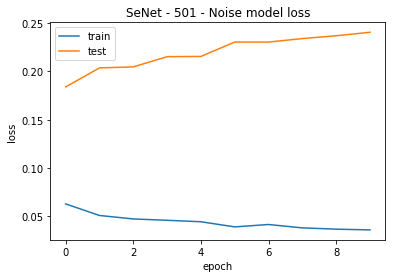

In [12]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('SeNet - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('SeNet - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L2.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#use set_weights to load the modelweights into the model architecture
NUM_GPU = 3

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [30]:
# Change LR=1e-6

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

NUM_GPU = 3
batch_size = 30

epochs = 15##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

if NUM_GPU != 1:
    model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl')

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)
savecheckpoint = SaveCheckPoint(model_2, savedfilename)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

# number of steps each epoch
step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, savecheckpoint],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9875
Saving val_acc 0.954000 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl
2000/2000 [==============================] - 1994s 997ms/step - loss: 0.0337 - acc: 0.9875 - val_loss: 0.2382 - val_acc: 0.9540
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9880
Saving val_acc 0.954100 at checkpoints/FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl
2000/2000 [==============================] - 1944s 972ms/step - loss: 0.0342 - acc: 0.9880 - val_loss: 0.2369 - val_acc: 0.9541
Epoch 3/15
2000/2000 [==============================] - 1941s 971ms/step - loss: 0.0318 - acc: 0.9883 - val_loss: 0.2391 - val_acc: 0.9540
Epoch 4/15
2000/2000 [==============================] - 1939s 970ms/step - loss: 0.0335 - acc: 0.9878 - val_loss: 0.2407 - val_acc: 0.9540
Epoch 5/15
2000/

KeyboardInterrupt: 

In [6]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#use set_weights to load the modelweights into the model architecture
NUM_GPU = 4

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

model_mul.set_weights(weigh)

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import time, os
from math import ceil

# PREDICT ON OFFICIAL TEST
train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 40

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_2310_01.csv')
results.head()

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
250/250 [==============================] - 98s 390ms/step


,file_name,predicted1
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0


In [15]:
results.tail()

,file_name,predicted1
9995,9/09967.png,9
9996,9/09973.png,9
9997,9/09978.png,9
9998,9/09993.png,9
9999,9/09995.png,9


In [16]:
cp FashionMNIST_SeResNet101_MulModels299_2310_01.csv /home/bribeiro/Phong/Nat19/FashionMNIST_SeResNet101_MulModels299_2310_01.csv

In [13]:
np.save(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_Mul.npy'), predict1)

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 30

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (320, 320),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 299)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 21
predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
    if NUM_GPU != 1:
        preds=model_mul.predict_generator(test_crops, 
                                           steps = step_size_test_crop,
#                                            max_queue_size=16,
#                                                use_multiprocessing=True,
#                                            workers=1,
                                           verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
#     preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv')
results.head(10)

Found 10000 images belonging to 10 classes.
0
334/334 [==============================] - 104s 311ms/step
1
334/334 [==============================] - 103s 310ms/step
2
334/334 [==============================] - 103s 309ms/step
3
334/334 [==============================] - 103s 309ms/step
4
334/334 [==============================] - 103s 309ms/step
5
334/334 [==============================] - 103s 310ms/step
6
334/334 [==============================] - 104s 310ms/step
7
334/334 [==============================] - 103s 310ms/step
8
334/334 [==============================] - 103s 309ms/step
9
334/334 [==============================] - 103s 309ms/step
10
334/334 [==============================] - 103s 307ms/step
11
334/334 [==============================] - 103s 310ms/step
12
334/334 [==============================] - 103s 308ms/step
13
334/334 [==============================] - 103s 308ms/step
14
334/334 [==============================] - 103s 309ms/step
15
334/334 [========================

,id,predicted
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0
5,0/00085.png,0
6,0/00088.png,0
7,0/00096.png,0
8,0/00113.png,0
9,0/00120.png,0


In [29]:
cp FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv /home/bribeiro/Phong/Nat19/FashionMNIST_SeResNet101_MulModels299_2310_tta_3_5.csv

In [ ]:
# Save weights in pickle format instead of h5
import pickle

#use get_weights() command to get your model weights
weigh= model_2.get_weights()

#now, use pickle to save your model weights, instead of .h5
#for heavy model architectures, .h5 file is unsupported.
pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG501_Mul_STD.pkl')

fpkl= open(pklfile, 'wb') #Python 3
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

In [ ]:
os.listdir("checkpoints")

In [8]:
# #use pickle to load model weights
# import os
# import pickle

# pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl')

# f= open(pklfile, 'rb')     #Python 3                 
# weigh= pickle.load(f);                
# f.close();

# #use set_weights to load the modelweights into the model architecture
# NUM_GPU = 4
# #Using multiple models if more than 1 GPU
# if NUM_GPU != 1:
#     model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

# model_mul.set_weights(weigh)

In [10]:
# model 2 - SeResNext101
#use pickle to load model weights
import os
import pickle

# load to multi gpu
NUM_GPU = 4
model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

#load model the saved weights
pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#set the saved weight to mul-gpus model
model_mul.set_weights(weigh)

f2_sgl = model_mul.layers[-2]

#get weight from single gpu
weigh= f2_sgl.get_weights()

#now, use pickle to save model weights, instead of .h5
#for heavy model architectures, .h5 file is unsupported.
pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3_SGL.pkl')

fpkl= open(pklfile, 'wb') #Python 3
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

In [11]:
#model 2 - SEResNext101
#load model the saved weights
pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3_SGL.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

#set the saved weight to mul-gpus model
model_2.set_weights(weigh)

In [12]:
# # load to multi gpu
# NUM_GPU = 4
# model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

# #get weight from mul gpu
# weigh= model_mul.get_weights()

# #now, use pickle to save model weights, instead of .h5
# #for heavy model architectures, .h5 file is unsupported.
# pklfile= os.path.join('checkpoints', 'FashionMNIST_SEResNext101_LRG299_Mul_LSTM_L3_SGL.pkl')

# fpkl= open(pklfile, 'wb') #Python 3
# pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
# fpkl.close()

In [13]:
#Set 1
#MUL 1 - Xception

# from keras.applications import InceptionV3
from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, Reshape, Bidirectional
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.xception import preprocess_input

from keras.layers import GaussianNoise

f1_base = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))  
f1_x = f1_base.output
f1_x = GlobalAveragePooling2D()(f1_x)

f1_x = Reshape([1,2048])(f1_x)  
f1_x = Bidirectional(LSTM(1024, 
                                 return_sequences=False, 
#                                  dropout=0.8
                                ),
                            input_shape=[1,2048],
                            merge_mode='concat')(f1_x)

#Regularization with noise
f1_x = GaussianNoise(0.1)(f1_x)

f1_x = Dense(2048, activation='relu')(f1_x)
f1_x = Dense(10, activation='softmax')(f1_x)
model_1 = Model(inputs=[f1_base.input],outputs=[f1_x])

print(model_1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [6]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 100

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/40
600/600 [==============================] - 748s 1s/step - loss: 0.5504 - acc: 0.8060 - val_loss: 0.3223 - val_acc: 0.8878
Epoch 2/40
600/600 [==============================] - 742s 1s/step - loss: 0.3371 - acc: 0.8780 - val_loss: 0.2509 - val_acc: 0.9112
Epoch 3/40
600/600 [==============================] - 742s 1s/step - loss: 0.2896 - acc: 0.8971 - val_loss: 0.2359 - val_acc: 0.9159
Epoch 4/40
600/600 [==============================] - 740s 1s/step - loss: 0.2704 - acc: 0.9029 - val_loss: 0.2401 - val_acc: 0.9169
Epoch 5/40
600/600 [==============================] - 744s 1s/step - loss: 0.2481 - acc: 0.9114 - val_loss: 0.2067 - val_acc: 0.9264
Epoch 6/40
120/600 [=====>........................] - ETA: 8:53 - loss: 0.2298 - acc: 0.9193

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 741s 1s/step - loss: 0.2121 - acc: 0.9238 - val_loss: 0.1965 - val_acc: 0.9312
Epoch 9/40
600/600 [==============================] - 744s 1s/step - loss: 0.1983 - acc: 0.9274 - val_loss: 0.1760 - val_acc: 0.9365
Epoch 10/40
600/600 [==============================] - 742s 1s/step - loss: 0.1928 - acc: 0.9294 - val_loss: 0.1739 - val_acc: 0.9384
Epoch 11/40
600/600 [==============================] - 743s 1s/step - loss: 0.1856 - acc: 0.9321 - val_loss: 0.1706 - val_acc: 0.9394
Epoch 12/40
600/600 [==============================] - 744s 1s/step - loss: 0.1775 - acc: 0.9347 - val_loss: 0.1604 - val_acc: 0.9415
Epoch 13/40
600/600 [==============================] - 741s 1s/step - loss: 0.1717 - acc: 0.9372 - val_loss: 0.1631 - val_acc: 0.9422
Epoch 14/40
600/600 [==============================] - 743s 1s/step - loss: 0.1638 - acc: 0.9395 - val_loss: 0.1590 - val_acc: 0.9438
Epoch 15/40
600/600 [==============================] - 743s 1s/step - loss:

Epoch 38/40
600/600 [==============================] - 742s 1s/step - loss: 0.0769 - acc: 0.9715 - val_loss: 0.2032 - val_acc: 0.9472
Epoch 39/40
600/600 [==============================] - 744s 1s/step - loss: 0.0752 - acc: 0.9723 - val_loss: 0.2109 - val_acc: 0.9495
Epoch 40/40
600/600 [==============================] - 742s 1s/step - loss: 0.0704 - acc: 0.9742 - val_loss: 0.2132 - val_acc: 0.9456


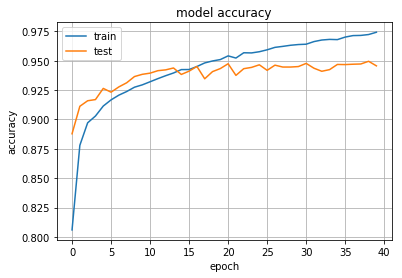

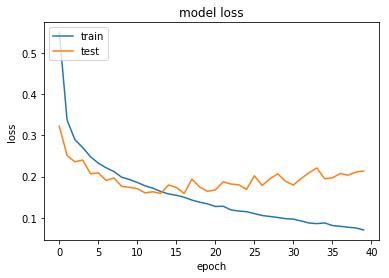

In [8]:
import matplotlib.pyplot as plt
history = result
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul.hdf5'))

In [12]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L2.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Epoch 1/15
600/600 [==============================] - 758s 1s/step - loss: 0.0552 - acc: 0.9799 - val_loss: 0.2141 - val_acc: 0.9513
Epoch 2/15
600/600 [==============================] - 742s 1s/step - loss: 0.0450 - acc: 0.9836 - val_loss: 0.2224 - val_acc: 0.9498
Epoch 3/15
600/600 [==============================] - 743s 1s/step - loss: 0.0446 - acc: 0.9837 - val_loss: 0.2260 - val_acc: 0.9491
Epoch 4/15
600/600 [==============================] - 747s 1s/step - loss: 0.0421 - acc: 0.9847 - val_loss: 0.2362 - val_acc: 0.9495
Epoch 5/15
600/600 [==============================] - 743s 1s/step - loss: 0.0396 - acc: 0.9859 - val_loss: 0.2348 - val_acc: 0.9511
Epoch 6/15
600/600 [==============================] - 743s 1s/step - loss: 0.0388 - acc: 0.9860 - val_loss: 0.2411 - val_acc: 0.9510
Epoch 7/15
600/600 [==============================] - 743s 1s/step - loss: 0.0366 - acc: 0.9865 - val_loss: 0.2456 - val_acc: 0.9507
Epoch 8/15
600/600 [==============================] - 745s 1s/step - 

In [8]:
#Using multiple models if more than 1 GPU
NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L2.hdf5'))

In [12]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 100

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

savedfilename = os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L3.hdf5')
checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True
earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

epochs = 15##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/15
600/600 [==============================] - 760s 1s/step - loss: 0.0338 - acc: 0.9877 - val_loss: 0.2464 - val_acc: 0.9520
Epoch 2/15
600/600 [==============================] - 743s 1s/step - loss: 0.0344 - acc: 0.9878 - val_loss: 0.2443 - val_acc: 0.9517
Epoch 3/15
600/600 [==============================] - 746s 1s/step - loss: 0.0332 - acc: 0.9880 - val_loss: 0.2443 - val_acc: 0.9521
Epoch 4/15
600/600 [==============================] - 746s 1s/step - loss: 0.0330 - acc: 0.9884 - val_loss: 0.2474 - val_acc: 0.9517
Epoch 5/15
600/600 [==============================] - 745s 1s/step - loss: 0.0344 - acc: 0.9873 - val_loss: 0.2472 - val_acc: 0.9513
Epoch 6/15
600/600 [==============================] - 748s 1s/step - loss: 0.0337 - acc: 0.9878 - val_loss: 0.2457 - val_acc: 0.9515
Epoch 7/15
600/600 [==============================] - 745s 1s/step - loss: 0.0343 - acc: 0.9877 - val_loss: 0.2472

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600/600 [==============================] - 743s 1s/step - loss: 0.0342 - acc: 0.9873 - val_loss: 0.2507 - val_acc: 0.9516
Epoch 15/15
600/600 [==============================] - 745s 1s/step - loss: 0.0319 - acc: 0.9885 - val_loss: 0.2510 - val_acc: 0.9511


In [13]:
import numpy as np

print(result.history['val_acc'])
print(np.mean(result.history['val_acc']))
print(np.max(result.history['val_acc']))

print(result.history['acc'])
print(np.mean(result.history['acc']))
print(np.max(result.history['acc']))

[0.9520000046491623, 0.9517000049352646, 0.9521000045537948, 0.9517000049352646, 0.951300003528595, 0.9515000027418137, 0.951300003528595, 0.9514000046253205, 0.9517000031471252, 0.9516000038385392, 0.9521000039577484, 0.9512000036239624, 0.952200003862381, 0.9516000044345856, 0.9511000049114228]
0.9516333374182382
0.952200003862381
[0.9877166755994161, 0.987750008602937, 0.9880333426594734, 0.9884000091751417, 0.9873333434263866, 0.9878333424528439, 0.9877000096440315, 0.9875000098347664, 0.9876000094413757, 0.9876166760921479, 0.9885166761279106, 0.9884666761755944, 0.9883500093221664, 0.9873166762789091, 0.9884500095248222]
0.9879055649571948
0.9885166761279106


In [20]:
#Using multiple models if more than 1 GPU
NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L3.hdf5'))

In [21]:
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_SeResNet101_MulModels299_2410_01.csv')
results.head()

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
100/100 [==============================] - 27s 275ms/step


,file_name,predicted1
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0


In [18]:
mkdir pred_npy

In [22]:
np.save(os.path.join('pred_npy','FashionMNIST_Xception_LRG299_Mul.npy'), predict1)

In [15]:
#model 1 - Xception
# load to multi gpu

#use hdf5
NUM_GPU = 4
model_mul = multi_gpu_model(model_1, gpus=NUM_GPU)

hdf5file= os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_L3.hdf5')
model_mul.load_weights(hdf5file)

f1_sgl = model_mul.layers[-2]
f1_sgl.save(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_LSTM_L3_SGL.hdf5'))

In [16]:
model_1.load_weights(os.path.join('checkpoints', 'FashionMNIST_Xception_LRG299_Mul_LSTM_L3_SGL.hdf5'))

In [ ]:
mkdir checkpoints

In [17]:
#501
#MUL 3 InceptionResNetV2
# from keras.applications import InceptionV3
# from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

f3_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))  
# for layer in f3_base.layers:
#     layer.trainable = False 
f3_x = f3_base.output
f3_x = GlobalAveragePooling2D()(f3_x)

#Regularization with noise
f3_x = GaussianNoise(0.1)(f3_x)

f3_x = Dense(2048, activation='relu')(f3_x)
f3_x = Dense(10, activation='softmax')(f3_x)
model_3 = Model(inputs=[f3_base.input],outputs=[f3_x])

print(model_3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1202 (Conv2D)            (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 149, 149, 32) 96          conv2d_1202[0][0]                
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 149, 149, 32) 0           batch_normalization_113[0][0]    
__________________________________________________________________________________________________
conv2d_120

In [4]:
from keras.callbacks import Callback
import pickle
import sys

#Stop training on val_acc
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

#Save large model using pickle formate instead of h5            
class SaveCheckPoint(Callback):
    def __init__(self, model, dest_folder):
        super(Callback, self).__init__()
        self.model = model
        self.dest_folder = dest_folder
        
        #initiate
        self.best_val_acc = 0
        self.best_val_loss = sys.maxsize #get max value
          
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs['val_acc']
        val_loss = logs['val_loss']

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            
            # Save weights in pickle format instead of h5
            print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
            weigh= self.model.get_weights()

            #now, use pickle to save your model weights, instead of .h5
            #for heavy model architectures, .h5 file is unsupported.
            fpkl= open(self.dest_folder, 'wb') #Python 3
            pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
            fpkl.close()
            
#             model.save('tmp.h5')
        elif val_acc == self.best_val_acc:
            if val_loss < self.best_val_loss:
                self.best_val_loss=val_loss
                
                # Save weights in pickle format instead of h5
                print('\nSaving val_acc %f at %s' %(self.best_val_acc, self.dest_folder))
                weigh= self.model.get_weights()

                #now, use pickle to save your model weights, instead of .h5
                #for heavy model architectures, .h5 file is unsupported.
                fpkl= open(self.dest_folder, 'wb') #Python 3
                pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
                fpkl.close()                    

In [11]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 120

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.9900, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_3, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 40##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/40
500/500 [==============================] - 811s 2s/step - loss: 0.4462 - acc: 0.8414 - val_loss: 0.2933 - val_acc: 0.8941
Epoch 2/40
500/500 [==============================] - 772s 2s/step - loss: 0.3145 - acc: 0.8879 - val_loss: 0.2263 - val_acc: 0.9173
Epoch 3/40
500/500 [==============================] - 775s 2s/step - loss: 0.2748 - acc: 0.8995 - val_loss: 0.2230 - val_acc: 0.9202
Epoch 4/40
500/500 [==============================] - 772s 2s/step - loss: 0.2504 - acc: 0.9093 - val_loss: 0.2147 - val_acc: 0.9230
Epoch 5/40
500/500 [==============================] - 768s 2s/step - loss: 0.2295 - acc: 0.9165 - val_loss: 0.2001 - val_acc: 0.9282
Epoch 6/40
500/500 [==============================] - 774s 2s/step - loss: 0.2188 - acc: 0.9199 - val_loss: 0.1892 - val_acc: 0.9310
Epoch 7/40
500/500 [==============================] - 771s 2s/step - loss: 0.2081 - acc: 0.9248 - val_loss: 0.2019

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 768s 2s/step - loss: 0.1150 - acc: 0.9567 - val_loss: 0.1693 - val_acc: 0.9463
Epoch 24/40
500/500 [==============================] - 770s 2s/step - loss: 0.1086 - acc: 0.9598 - val_loss: 0.1708 - val_acc: 0.9467
Epoch 25/40
500/500 [==============================] - 775s 2s/step - loss: 0.1054 - acc: 0.9611 - val_loss: 0.1686 - val_acc: 0.9481
Epoch 26/40
500/500 [==============================] - 769s 2s/step - loss: 0.1026 - acc: 0.9614 - val_loss: 0.1863 - val_acc: 0.9470
Epoch 27/40
500/500 [==============================] - 773s 2s/step - loss: 0.1022 - acc: 0.9628 - val_loss: 0.1835 - val_acc: 0.9429
Epoch 28/40
500/500 [==============================] - 773s 2s/step - loss: 0.0959 - acc: 0.9646 - val_loss: 0.1858 - val_acc: 0.9447
Epoch 29/40
500/500 [==============================] - 772s 2s/step - loss: 0.0929 - acc: 0.9654 - val_loss: 0.1777 - val_acc: 0.9459
Epoch 30/40
500/500 [==============================] - 773s 2s/step - loss

In [13]:
#Using multiple models if more than 1 GPU
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul.hdf5'))

In [14]:
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########
epochs = 15##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

Epoch 1/15
500/500 [==============================] - 835s 2s/step - loss: 0.0807 - acc: 0.9696 - val_loss: 0.1695 - val_acc: 0.9512
Epoch 2/15
500/500 [==============================] - 776s 2s/step - loss: 0.0683 - acc: 0.9750 - val_loss: 0.1689 - val_acc: 0.9527
Epoch 3/15
500/500 [==============================] - 776s 2s/step - loss: 0.0624 - acc: 0.9776 - val_loss: 0.1748 - val_acc: 0.9520
Epoch 4/15
500/500 [==============================] - 779s 2s/step - loss: 0.0581 - acc: 0.9790 - val_loss: 0.1827 - val_acc: 0.9513
Epoch 5/15
500/500 [==============================] - 777s 2s/step - loss: 0.0571 - acc: 0.9789 - val_loss: 0.1850 - val_acc: 0.9510
Epoch 6/15
500/500 [==============================] - 780s 2s/step - loss: 0.0523 - acc: 0.9813 - val_loss: 0.1937 - val_acc: 0.9521
Epoch 7/15
500/500 [==============================] - 777s 2s/step - loss: 0.0506 - acc: 0.9817 - val_loss: 0.1952 - val_acc: 0.9513
Epoch 8/15
500/500 [==============================] - 776s 2s/step - 

In [15]:
#Using multiple models if more than 1 GPU
model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5'))

In [16]:
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L3.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########
epochs = 5##!!!
lr = 1e-6
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping, checkpointer],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 
  

Epoch 1/5
500/500 [==============================] - 843s 2s/step - loss: 0.0390 - acc: 0.9855 - val_loss: 0.2094 - val_acc: 0.9528
Epoch 2/5
500/500 [==============================] - 777s 2s/step - loss: 0.0396 - acc: 0.9859 - val_loss: 0.2084 - val_acc: 0.9519
Epoch 3/5
500/500 [==============================] - 777s 2s/step - loss: 0.0382 - acc: 0.9867 - val_loss: 0.2104 - val_acc: 0.9521
Epoch 4/5
500/500 [==============================] - 777s 2s/step - loss: 0.0387 - acc: 0.9857 - val_loss: 0.2111 - val_acc: 0.9529
Epoch 5/5
500/500 [==============================] - 776s 2s/step - loss: 0.0398 - acc: 0.9853 - val_loss: 0.2114 - val_acc: 0.9521


In [8]:
#Using multiple models if more than 1 GPU
import os

NUM_GPU = 4
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_3, gpus=NUM_GPU)

model_mul.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5'))

In [19]:
#model 1 - InceptionResNetV2
# load to multi gpu

#use hdf5
NUM_GPU = 4
model_mul = multi_gpu_model(model_3, gpus=NUM_GPU)

hdf5file= os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2.hdf5')
model_mul.load_weights(hdf5file)

f1_sgl = model_mul.layers[-2]
f1_sgl.save(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2_SGL.hdf5'))

In [20]:
model_3.load_weights(os.path.join('checkpoints', 'FashionMNIST_IcpResNetV2_LRG299_Mul_L2_SGL.hdf5'))

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

batch_size = 120

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('FashionMNIST_IcpResNetV2_MulModels299_2510_01.csv')
results.head()

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
84/84 [==============================] - 45s 537ms/step


,file_name,predicted1
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0


In [12]:
np.save(os.path.join('pred_npy','FashionMNIST_IcpResNetV2_LRG299_Mul.npy'), predict1)

In [13]:
mean_pred3_1 = np.load(os.path.join('pred_npy','FashionMNIST_SEResNext101_LRG299_Mul.npy'))
mean_pred3_2 = np.load(os.path.join('pred_npy','FashionMNIST_Xception_LRG299_Mul.npy'))
mean_pred3_3 = np.load(os.path.join('pred_npy','FashionMNIST_IcpResNetV2_LRG299_Mul.npy'))
mean_pred3 = (mean_pred3_1+mean_pred3_2+mean_pred3_3)/3
print(mean_pred3[0:9])

[[9.99971092e-01 6.41624576e-09 1.09336843e-05 3.42880270e-07
  1.01663591e-06 1.00072235e-08 1.61061762e-05 3.83562915e-09
  2.25882502e-07 3.34057944e-07]
 [9.98679817e-01 1.84337801e-09 1.89170157e-06 4.11466999e-07
  1.64542568e-09 3.66051321e-11 1.31790002e-03 1.00779463e-11
  3.45051610e-09 9.24798294e-10]
 [9.99867737e-01 7.09229608e-09 2.63728452e-06 4.23222872e-07
  5.12074756e-08 1.89283060e-08 1.29059015e-04 1.41668766e-09
  4.05425560e-08 4.74289585e-08]
 [9.99998510e-01 1.60690645e-11 6.90580009e-07 2.63589217e-09
  5.28082111e-09 3.28646199e-09 8.32415537e-07 3.09770182e-10
  9.77256387e-10 8.21340551e-10]
 [9.99979734e-01 1.76849247e-12 1.82342192e-05 1.27799649e-09
  1.64325487e-09 1.16526927e-12 2.01666012e-06 2.42484960e-13
  5.10400472e-11 4.54124183e-10]
 [9.99999821e-01 2.73740037e-12 3.40630013e-09 1.69580394e-09
  9.09302147e-11 8.06415004e-11 1.28914181e-07 4.39680540e-12
  4.70394730e-11 1.87992247e-10]
 [9.99999821e-01 1.34957421e-12 8.34295033e-09 6.21985485e

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 20

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

train_datagen = ImageDataGenerator(

)

train_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )
        
test_datagen_crop = ImageDataGenerator(
)

testing_set_crop = test_datagen_crop.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 299)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

predicted_class_indices_mean=np.argmax(mean_pred3,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('FashionMNIST_MulModels299_AVG_Assembe_V2_2510_2.csv')
results.head(20)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


,id,predicted
0,0/00019.png,0
1,0/00027.png,0
2,0/00035.png,0
3,0/00059.png,0
4,0/00071.png,0
5,0/00085.png,0
6,0/00088.png,0
7,0/00096.png,0
8,0/00113.png,0
9,0/00120.png,0


In [15]:
cp FashionMNIST_MulModels299_AVG_Assembe_V2_2510_2.csv /home/bribeiro/Phong/Nat19/FashionMNIST_MulModels299_AVG_Assembe_V2_2510_2.csv

In [ ]:
model_1.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Xception_LRG501_Mul_Pretrained_STD_SGL.hdf5'))
# model_2.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Inception_LRG501_Mul_Pretrained_STD_SGL.hdf5'))
model_3.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_IcpResNetV2_LRG501_Mul_Pretrained_STD_SGL.hdf5'))

In [25]:
# 3 models
# 501
# pre-trainned weight
# get pretrained [-1] layer

from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, LeakyReLU, Dropout
#from keras.applications.inception_v3 import preprocess_input
from keras_applications.imagenet_utils import preprocess_input

f1_mul_x = model_1.layers[-1].output 
f2_mul_x = model_2.layers[-1].output
f3_mul_x = model_3.layers[-1].output

x = concatenate([f1_mul_x, f2_mul_x, f3_mul_x])

x = Dense(4096)(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model_mul = Model(inputs=[model_1.get_input_at(0),model_2.get_input_at(0),model_3.get_input_at(0)],outputs=[x])

print(model_mul.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

                                                                 activation_181[0][0]             
                                                                 activation_184[0][0]             
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 38, 38, 512)  2048        conv2d_253[0][0]                 
__________________________________________________________________________________________________
block35_1_conv (Conv2D)         (None, 35, 35, 320)  41280       block35_1_mixed[0][0]            
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 512)          0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
block35_1 (Lambda)              (None, 35, 35, 320)  0           mixed_5b[0][0]                   
          

conv2d_402 (Conv2D)             (None, 19, 19, 16)   2304        lambda_364[0][0]                 
__________________________________________________________________________________________________
conv2d_403 (Conv2D)             (None, 19, 19, 16)   2304        lambda_365[0][0]                 
__________________________________________________________________________________________________
conv2d_404 (Conv2D)             (None, 19, 19, 16)   2304        lambda_366[0][0]                 
__________________________________________________________________________________________________
conv2d_405 (Conv2D)             (None, 19, 19, 16)   2304        lambda_367[0][0]                 
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 19, 19, 16)   2304        lambda_368[0][0]                 
__________________________________________________________________________________________________
conv2d_407

conv2d_582 (Conv2D)             (None, 19, 19, 16)   2304        lambda_529[0][0]                 
__________________________________________________________________________________________________
conv2d_583 (Conv2D)             (None, 19, 19, 16)   2304        lambda_530[0][0]                 
__________________________________________________________________________________________________
conv2d_584 (Conv2D)             (None, 19, 19, 16)   2304        lambda_531[0][0]                 
__________________________________________________________________________________________________
conv2d_585 (Conv2D)             (None, 19, 19, 16)   2304        lambda_532[0][0]                 
__________________________________________________________________________________________________
conv2d_586 (Conv2D)             (None, 19, 19, 16)   2304        lambda_533[0][0]                 
__________________________________________________________________________________________________
conv2d_587

                                                                 conv2d_801[0][0]                 
                                                                 conv2d_802[0][0]                 
                                                                 conv2d_803[0][0]                 
                                                                 conv2d_804[0][0]                 
                                                                 conv2d_805[0][0]                 
                                                                 conv2d_806[0][0]                 
                                                                 conv2d_807[0][0]                 
                                                                 conv2d_808[0][0]                 
                                                                 conv2d_809[0][0]                 
                                                                 conv2d_810[0][0]                 
          

__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 19, 19, 728)  0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
lambda_957 (Lambda)             (None, 1, 1, 1024)   0           global_average_pooling2d_29[0][0]
__________________________________________________________________________________________________
conv2d_1379 (Conv2D)            (None, 8, 8, 224)    129024      activation_343[0][0]             
__________________________________________________________________________________________________
block5_sepconv3 (SeparableConv2 (None, 19, 19, 728)  536536      block5_sepconv3_act[0][0]        
__________________________________________________________________________________________________
conv2d_1047 (Conv2D)            (None, 1, 1, 64)     65600       lambda_957[0][0]                 
__________

In [22]:
for layer in model_mul.layers[:-4]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_mul.layers):
    print(i,layer.name,layer.trainable)

0 input False
1 zero_padding2d_1 False
2 conv2d_1 False
3 batch_normalization_1 False
4 activation_1 False
5 zero_padding2d_2 False
6 max_pooling2d_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 zero_padding2d_3 False
11 lambda_1 False
12 lambda_2 False
13 lambda_3 False
14 lambda_4 False
15 lambda_5 False
16 lambda_6 False
17 lambda_7 False
18 lambda_8 False
19 lambda_9 False
20 lambda_10 False
21 lambda_11 False
22 lambda_12 False
23 lambda_13 False
24 lambda_14 False
25 lambda_15 False
26 lambda_16 False
27 lambda_17 False
28 lambda_18 False
29 lambda_19 False
30 lambda_20 False
31 lambda_21 False
32 lambda_22 False
33 lambda_23 False
34 lambda_24 False
35 lambda_25 False
36 lambda_26 False
37 lambda_27 False
38 lambda_28 False
39 lambda_29 False
40 lambda_30 False
41 lambda_31 False
42 lambda_32 False
43 conv2d_3 False
44 conv2d_4 False
45 conv2d_5 False
46 conv2d_6 False
47 conv2d_7 False
48 conv2d_8 False
49 conv2d_9 False
50 conv2d_10 False
51 con

869 block35_4 False
870 global_average_pooling2d_9 False
871 block35_4_ac False
872 lambda_297 False
873 conv2d_1241 False
874 conv2d_327 False
875 batch_normalization_152 False
876 activation_44 False
877 activation_206 False
878 conv2d_328 False
879 conv2d_1239 False
880 conv2d_1242 False
881 activation_45 False
882 batch_normalization_150 False
883 batch_normalization_153 False
884 multiply_9 False
885 activation_204 False
886 activation_207 False
887 add_9 False
888 conv2d_1238 False
889 conv2d_1240 False
890 conv2d_1243 False
891 activation_46 False
892 batch_normalization_149 False
893 batch_normalization_151 False
894 batch_normalization_154 False
895 conv2d_329 False
896 activation_203 False
897 activation_205 False
898 activation_208 False
899 batch_normalization_32 False
900 block35_5_mixed False
901 activation_47 False
902 block35_5_conv False
903 zero_padding2d_12 False
904 block35_5 False
905 lambda_298 False
906 lambda_299 False
907 lambda_300 False
908 lambda_301 False
9

1814 lambda_588 False
1815 lambda_589 False
1816 lambda_590 False
1817 lambda_591 False
1818 lambda_592 False
1819 lambda_593 False
1820 conv2d_1302 False
1821 conv2d_1305 False
1822 conv2d_618 False
1823 conv2d_619 False
1824 conv2d_620 False
1825 conv2d_621 False
1826 conv2d_622 False
1827 conv2d_623 False
1828 conv2d_624 False
1829 conv2d_625 False
1830 conv2d_626 False
1831 conv2d_627 False
1832 conv2d_628 False
1833 conv2d_629 False
1834 conv2d_630 False
1835 conv2d_631 False
1836 conv2d_632 False
1837 conv2d_633 False
1838 conv2d_634 False
1839 conv2d_635 False
1840 conv2d_636 False
1841 conv2d_637 False
1842 conv2d_638 False
1843 conv2d_639 False
1844 conv2d_640 False
1845 conv2d_641 False
1846 conv2d_642 False
1847 conv2d_643 False
1848 conv2d_644 False
1849 conv2d_645 False
1850 conv2d_646 False
1851 conv2d_647 False
1852 conv2d_648 False
1853 conv2d_649 False
1854 batch_normalization_213 False
1855 batch_normalization_216 False
1856 concatenate_18 False
1857 activation_267 Fa

2782 batch_normalization_269 False
2783 batch_normalization_271 False
2784 batch_normalization_274 False
2785 conv2d_942 False
2786 conv2d_943 False
2787 conv2d_944 False
2788 conv2d_945 False
2789 conv2d_946 False
2790 conv2d_947 False
2791 conv2d_948 False
2792 conv2d_949 False
2793 conv2d_950 False
2794 conv2d_951 False
2795 conv2d_952 False
2796 conv2d_953 False
2797 conv2d_954 False
2798 conv2d_955 False
2799 conv2d_956 False
2800 conv2d_957 False
2801 conv2d_958 False
2802 conv2d_959 False
2803 conv2d_960 False
2804 conv2d_961 False
2805 conv2d_962 False
2806 conv2d_963 False
2807 conv2d_964 False
2808 conv2d_965 False
2809 conv2d_966 False
2810 conv2d_967 False
2811 conv2d_968 False
2812 conv2d_969 False
2813 conv2d_970 False
2814 conv2d_971 False
2815 conv2d_972 False
2816 conv2d_973 False
2817 activation_323 False
2818 activation_325 False
2819 activation_328 False
2820 concatenate_27 False
2821 conv2d_1359 False
2822 conv2d_1361 False
2823 conv2d_1364 False
2824 batch_normali

In [23]:
# generators for three inputs
def train_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator(    
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,##
    #     brightness_range=[0.5, 1.5],##
        channel_shift_range=10,##
        fill_mode='nearest')
    
    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, seed=1, target_size = (299, 299))    
    while True:
        X1i = genX1.next()
        yield [X1i[0], X1i[0], X1i[0]], X1i[1]
        
def valid_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator()

    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, seed=1, target_size = (299, 299))        
    while True:
        X1i = genX1.next()
        yield [X1i[0], X1i[0], X1i[0]], X1i[1]    
    
def test_generator_three_img(X1, batch_size):
    gen = ImageDataGenerator(
#         preprocessing_function=preprocess_input
    )

    genX1 = gen.flow_from_directory(X1, batch_size=batch_size, shuffle=False, target_size = (299, 299))        
    while True:
        X1i_0, X1i_1 = next(genX1)
        yield [X1i_0, X1i_0, X1i_0]            

In [26]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                   output_shape=input_shape,
                                   arguments={'i': i,
                                              'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                    axis=0, name=name))
        return Model(model.inputs, merged)

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 120

training_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_LRG299_Mul_Pretrained_SeNet_Xcep_IcpRes_LSTM.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=False)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_mul, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# else:
#     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(training_set.n/training_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_generator_three_img('fashion_mnist_train_resized_299',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('fashion_mnist_test_resized_299',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1)    

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/30
Found 60000 images belonging to 10 classes.
500/500 [==============================] - 1071s 2s/step - loss: 1.8401 - acc: 0.9048 - val_loss: 1.4081 - val_acc: 0.9577
Epoch 2/30
500/500 [==============================] - 1042s 2s/step - loss: 0.9637 - acc: 0.9932 - val_loss: 0.6870 - val_acc: 0.9569
Epoch 3/30
500/500 [==============================] - 1041s 2s/step - loss: 0.4063 - acc: 0.9933 - val_loss: 0.3547 - val_acc: 0.9583
Epoch 4/30
500/500 [==============================] - 1041s 2s/step - loss: 0.1836 - acc: 0.9929 - val_loss: 0.2463 - val_acc: 0.9569
Epoch 5/30
500/500 [==============================] - 1042s 2s/step - loss: 0.1017 - acc: 0.9934 - val_loss: 0.2128 - val_acc: 0.9586
Epoch 6/30
500/500 [==============================] - 1045s 2s/step - loss: 0.0658 - acc: 0.9933 - val_loss: 0.1963 - val_acc: 0.9592
Epoch 7/30
500/500 [==============================] - 1043s 2s/s

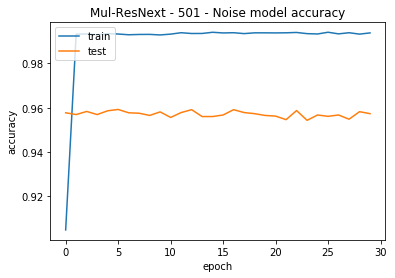

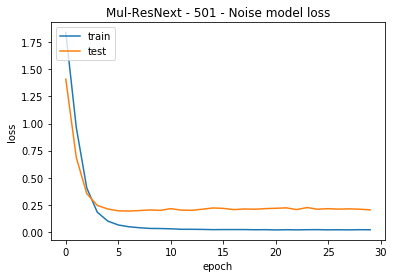

In [28]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# 3 models
# 501
# pre-trainned weight
# get pretrained [-1] layer

from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM, LeakyReLU, Dropout
#from keras.applications.inception_v3 import preprocess_input
from keras_applications.imagenet_utils import preprocess_input

f1_mul_x = model_1.layers[-1].output 
f2_mul_x = model_2.layers[-1].output
f3_mul_x = model_3.layers[-1].output

x = concatenate([f1_mul_x, f2_mul_x, f3_mul_x])

x = Reshape([1,30])(x)  
x = Bidirectional(LSTM(1024, 
                                 return_sequences=False, 
#                                  dropout=0.8
                                ),
                            input_shape=[1,30],
                            merge_mode='concat')(x)

# x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model_mul = Model(inputs=[model_1.get_input_at(0),model_2.get_input_at(0),model_3.get_input_at(0)],outputs=[x])

print(model_mul.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 305, 305, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

batch_normalization_114 (BatchN (None, 147, 147, 32) 96          conv2d_1203[0][0]                
__________________________________________________________________________________________________
add_5 (Add)                     (None, 38, 38, 512)  0           multiply_5[0][0]                 
                                                                 activation_21[0][0]              
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 147, 147, 32) 0           batch_normalization_114[0][0]    
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 38, 38, 512)  0           add_5[0][0]                      
__________________________________________________________________________________________________
conv2d_1204 (Conv2D)            (None, 147, 147, 64) 18432       activation_168[0][0]             
__________

conv2d_324 (Conv2D)             (None, 19, 19, 16)   2304        lambda_295[0][0]                 
__________________________________________________________________________________________________
conv2d_325 (Conv2D)             (None, 19, 19, 16)   2304        lambda_296[0][0]                 
__________________________________________________________________________________________________
conv2d_1232 (Conv2D)            (None, 35, 35, 32)   10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
conv2d_1234 (Conv2D)            (None, 35, 35, 32)   9216        activation_198[0][0]             
__________________________________________________________________________________________________
conv2d_1237 (Conv2D)            (None, 35, 35, 64)   27648       activation_201[0][0]             
__________________________________________________________________________________________________
concatenat

__________________________________________________________________________________________________
lambda_424 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
lambda_425 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
lambda_426 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
lambda_427 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
lambda_428 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_15[0][0]          
__________

__________________________________________________________________________________________________
lambda_550 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
lambda_551 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
lambda_552 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
lambda_553 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
lambda_554 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_19[0][0]          
__________

conv2d_741 (Conv2D)             (None, 19, 19, 16)   2304        lambda_676[0][0]                 
__________________________________________________________________________________________________
conv2d_742 (Conv2D)             (None, 19, 19, 16)   2304        lambda_677[0][0]                 
__________________________________________________________________________________________________
conv2d_743 (Conv2D)             (None, 19, 19, 16)   2304        lambda_678[0][0]                 
__________________________________________________________________________________________________
conv2d_744 (Conv2D)             (None, 19, 19, 16)   2304        lambda_679[0][0]                 
__________________________________________________________________________________________________
conv2d_745 (Conv2D)             (None, 19, 19, 16)   2304        lambda_680[0][0]                 
__________________________________________________________________________________________________
conv2d_746

conv2d_879 (Conv2D)             (None, 19, 19, 16)   2304        lambda_802[0][0]                 
__________________________________________________________________________________________________
conv2d_880 (Conv2D)             (None, 19, 19, 16)   2304        lambda_803[0][0]                 
__________________________________________________________________________________________________
conv2d_881 (Conv2D)             (None, 19, 19, 16)   2304        lambda_804[0][0]                 
__________________________________________________________________________________________________
conv2d_882 (Conv2D)             (None, 19, 19, 16)   2304        lambda_805[0][0]                 
__________________________________________________________________________________________________
conv2d_883 (Conv2D)             (None, 19, 19, 16)   2304        lambda_806[0][0]                 
__________________________________________________________________________________________________
conv2d_884

lambda_949 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
lambda_950 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
lambda_951 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
lambda_952 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
lambda_953 (Lambda)             (None, 21, 21, 16)   0           zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
lambda_954

block11_sepconv3_bn (BatchNorma (None, 19, 19, 728)  2912        block11_sepconv3[0][0]           
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 1, 1, 128)    0           conv2d_1156[0][0]                
__________________________________________________________________________________________________
conv2d_1398 (Conv2D)            (None, 8, 8, 192)    399360      block8_8_ac[0][0]                
__________________________________________________________________________________________________
add_55 (Add)                    (None, 19, 19, 728)  0           block11_sepconv3_bn[0][0]        
                                                                 add_54[0][0]                     
__________________________________________________________________________________________________
conv2d_1157 (Conv2D)            (None, 1, 1, 2048)   264192      activation_159[0][0]             
__________

In [31]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

## fix for multi_gpu_model prediction time longer
from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 120

training_set = train_datagen.flow_from_directory('fashion_mnist_train_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('fashion_mnist_test_resized_299',
                                                 target_size = (299, 299),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'FashionMNIST_LRG299_Mul_Pretrained_SeNet_Xcep_IcpRes_BiLSTM.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=False)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('fmnist_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('fmnist_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_mul, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# else:
#     model.load_weights(savedfilename)

epochs = 20##!!!
lr = 1e-4
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(training_set.n/training_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_generator_three_img('fashion_mnist_train_resized_299',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('fashion_mnist_test_resized_299',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1)    

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/20
Found 60000 images belonging to 10 classes.
500/500 [==============================] - 1109s 2s/step - loss: 0.8751 - acc: 0.9899 - val_loss: 0.2206 - val_acc: 0.9573
Epoch 2/20
500/500 [==============================] - 1068s 2s/step - loss: 0.0504 - acc: 0.9933 - val_loss: 0.2017 - val_acc: 0.9558
Epoch 3/20
500/500 [==============================] - 1068s 2s/step - loss: 0.0306 - acc: 0.9931 - val_loss: 0.2066 - val_acc: 0.9572
Epoch 4/20
500/500 [==============================] - 1074s 2s/step - loss: 0.0262 - acc: 0.9929 - val_loss: 0.2066 - val_acc: 0.9568
Epoch 5/20
500/500 [==============================] - 1074s 2s/step - loss: 0.0236 - acc: 0.9933 - val_loss: 0.2113 - val_acc: 0.9563
Epoch 6/20
500/500 [==============================] - 1078s 2s/step - loss: 0.0216 - acc: 0.9933 - val_loss: 0.2103 - val_acc: 0.9575
Epoch 7/20
500/500 [==============================] - 1106s 2s/s

KeyboardInterrupt: 

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v1.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v1.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v1.csv

In [ ]:
#MULTI GPUS

from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator_three_models(batches, crop_length):
    """Generate random crops from the image batches"""
     
    while True:
        batch_x, _ = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield [batch_crops, batch_crops, batch_crops]

gen = ImageDataGenerator(
#     rescale = 1./255,
#         preprocessing_function=preprocess_input
)

genX1 = gen.flow_from_directory('test',
                                 target_size = (541, 541),
                                 batch_size = batch_size,
                                 class_mode = 'categorical',
                                 shuffle=False,
                                 seed=7,
                              )

#steps
step_size_test_crop = ceil(genX1.n/genX1.batch_size)

#customized generator
test_crops = crop_generator_three_models(genX1, 501)

#number of crops
tta_steps = 7
# predictions = []

for i in range(tta_steps):
    print('iteration = %d' %i)
    #reset index
    genX1.reset()
    
    preds=model_mul.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v5.csv')
results.head(11)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v5.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v5.csv

In [ ]:
import pickle

#use get_weights() command to get your model weights
weigh= model_mul.get_weights()

#now, use pickle to save your model weights, instead of .h5
#for heavy model architectures, .h5 file is unsupported.
pklfile= os.path.join('checkpoints', 'Cassava_NonGrp_S1_LRG501_Mul_Pretrained_STD_09076.pkl')

fpkl= open(pklfile, 'wb') #Python 3
pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
fpkl.close()

In [ ]:
#use pickle to load model weights

pklfile= os.path.join('checkpoints', 'Cassava_NonGrp_S1_LRG501_Mul_Pretrained_STD_09076.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

gpus_model_mul = multi_gpu_model(model_mul, gpus=NUM_GPU)
#use set_weights to load the modelweights into the model architecture
gpus_model_mul.set_weights(weigh)

In [ ]:
epochs = 50##!!!

result = model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1)    

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v6.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v6.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v6.csv

In [ ]:
epochs = 10##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.91, verbose=1)

result = model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.913, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=gpus_model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v8.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v8.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v8.csv

In [ ]:
#MULTI GPUS

from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator_three_models(batches, crop_length):
    """Generate random crops from the image batches"""
     
    while True:
        batch_x, _ = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield [batch_crops, batch_crops, batch_crops]

gen = ImageDataGenerator(
#     rescale = 1./255,
#         preprocessing_function=preprocess_input
)

genX1 = gen.flow_from_directory('test',
                                 target_size = (541, 541),
                                 batch_size = batch_size,
                                 class_mode = 'categorical',
                                 shuffle=False,
                                 seed=7,
                              )

#steps
step_size_test_crop = ceil(genX1.n/genX1.batch_size)

#customized generator
test_crops = crop_generator_three_models(genX1, 501)

#number of crops
tta_steps = 5
predictions = []

for i in range(tta_steps):
    print('iteration = %d / %d' %(i+1,tta_steps))
    #reset index
    genX1.reset()
    
    preds=gpus_model_mul.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v10.csv')
results.head(11)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v10.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v11.csv

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.919, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Mul-ResNext - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Mul-ResNext - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#change test_generator
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=gpus_model_mul.predict_generator(test_generator_three_img('test',batch_size), steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels501_2208_v12.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels501_2208_v12.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels501_2208_v12.csv

In [ ]:
#train after reload weight (val_acc: 0.9076)

epochs = 40##!!!

# lr = 1e-5
# decay = lr/epochs
lr = 1e-6
decay = 0
optimizer = Adam(lr=lr, decay=decay)
gpus_model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.925, verbose=1)

result = gpus_model_mul.fit_generator(
    generator = train_generator_three_img('train',batch_size=batch_size), 
    steps_per_epoch = step_size_train,
    validation_data = valid_generator_three_img('valid',batch_size=batch_size),
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping], 
    verbose=1) 

In [ ]:
#seresnext50
#Non-Groups
#Split training and validation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 20

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG501_Mul_Pretrained_STD_L4.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8870, verbose=1)##!!!!!!

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_2, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
#     callbacks=[tb, csv_logger, checkpointer, earlystopping], 
    callbacks=[tb, csv_logger, earlystopping],
    verbose=1) 

In [ ]:
#0.8898756673450369
#0.8827708640911651
max(result.history['val_acc'])

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# list all data in history
# history = result.history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('SeNet50 - 501 - Noise model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('SeNet50 - 501 - Noise model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_mul.save_weights(savedfilename)

In [ ]:
model_mul.save_weights(savedfilename)
f2_sgl = model_mul.layers[-2]
f2_sgl.save(os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG450_Mul_Pretrained_STD_L3_SGL.hdf5'))

In [ ]:
import numpy as np

# PREDICT ON OFFICIAL TEST
test_datagen1 = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (450, 450),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

test_set1 = test_datagen1.flow_from_directory('test',
                                                 target_size = (450, 450),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

if NUM_GPU != 1:
    predict1=model_mul.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
# else:
#     predict1=model.predict_generator(test_set1, steps = ceil(test_set1.n/test_set1.batch_size),verbose=1)
    
predicted_class_indices=np.argmax(predict1,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions1 = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_set1.filenames
results=pd.DataFrame({"file_name":filenames,
                      "predicted1":predictions1,
                      })
results.to_csv('Cassava_NonGrp_MulModels450_2108_v1.csv')
results.head()

In [ ]:
cp Cassava_NonGrp_MulModels450_2108_v1.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels450_2108_v1.csv

In [ ]:
model_2.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_SEResNext50_LRG450_Mul_Pretrained_STD_L3_SGL.hdf5'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import numpy as np

batch_size = 20

#Crop-Official Test
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Generate random crops from the image batches"""
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

test_datagen_crop = ImageDataGenerator(
#     rescale = 1./255,
    preprocessing_function=preprocess_input
)

testing_set_crop = test_datagen_crop.flow_from_directory('test',
                                                 target_size = (500, 500),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="training"
                                              )
#customized generator
test_crops = crop_generator(testing_set_crop, 450)

step_size_test_crop = ceil(testing_set_crop.n/testing_set_crop.batch_size)

tta_steps = 3
predictions = []

# import tensorflow as tf
# with tf.device('/gpu:0'):
for i in range(tta_steps):
    print(i)
    testing_set_crop.reset()
#     if NUM_GPU != 1:
#         preds=mul_model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)    
#     else:
#         preds=model.predict_generator(test_crops, 
#                                            steps = step_size_test_crop,
#                                            max_queue_size=16,
# #                                                use_multiprocessing=True,
#                                            workers=1,
#                                            verbose=1)  
    preds=model_2.predict_generator(test_crops,steps = step_size_test_crop,verbose=1)  
    predictions.append(preds)

mean_pred = np.mean(predictions, axis=0)

predicted_class_indices_mean=np.argmax(mean_pred,axis=1)
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
finalpre = [labels[k] for k in predicted_class_indices_mean]

import pandas as pd
filenames=testing_set_crop.filenames
results=pd.DataFrame({"id":filenames,
                      "predicted":finalpre,
                      })
results.to_csv('Cassava_NonGrp_MulModels450_2108_v3.csv')
results.head(10)

In [ ]:
cp Cassava_NonGrp_MulModels450_2108_v3.csv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_MulModels450_2108_v3.csv

In [ ]:
result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

nasnet, preprocess_input = Classifiers.get('senet154')

f4_base = nasnet(input_shape=(501,501,3), weights=None, include_top=False)

f4_x = GlobalAveragePooling2D()(f4_base.output)

# # #Regularization with noise
f4_x = GaussianNoise(0.1)(f4_x)

f4_x = Dense(2048, activation='relu')(f4_x)
f4_x = Dense(5, activation='softmax')(f4_x)
model_4 = Model(inputs=[f4_base.input],outputs=[f4_x])

print(model_4.summary())
# # print(f2_base.summary())

In [ ]:
ls -l

In [ ]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('Cassava_NonGrp_S1_SENet154_LRG501_STD.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# restoredmodel= mymodel()
#use set_weights to load the modelweights into the model architecture
model_4.set_weights(weigh)

In [ ]:
for layer in model_4.layers[:-4]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_4.layers):
    print(i,layer.name,layer.trainable)

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 80

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_SENet154_LRG501_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8850, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_4, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
!wget https://github.com/qubvel/classification_models/releases/download/0.0.1/senet154_imagenet_1000_no_top.h5

In [ ]:
mv /home/bribeiro/Phong/Nat19/Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl 

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

nasnet, preprocess_input = Classifiers.get('nasnetlarge')

f4_base = nasnet(input_shape=(501,501,3), weights=None, include_top=False)

f4_x = GlobalAveragePooling2D()(f4_base.output)

# # #Regularization with noise
f4_x = GaussianNoise(0.1)(f4_x)

f4_x = Dense(2048, activation='relu')(f4_x)
f4_x = Dense(5, activation='softmax')(f4_x)
model_4 = Model(inputs=[f4_base.input],outputs=[f4_x])

print(model_4.summary())
# # print(f2_base.summary())

In [ ]:
#use pickle to load model weights
import os
import pickle

pklfile= os.path.join('Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.pkl')

f= open(pklfile, 'rb')     #Python 3                 
weigh= pickle.load(f);                
f.close();

# restoredmodel= mymodel()
#use set_weights to load the modelweights into the model architecture
model_4.set_weights(weigh)

In [ ]:
#Non-Groups
#Split training and validation
#Using Expert Data

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.utils import multi_gpu_model

import time, os
from math import ceil
import multiprocessing

train_datagen = ImageDataGenerator(
#     rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,##
#     brightness_range=[0.5, 1.5],##
    channel_shift_range=10,##
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
#     rescale = 1./255
    preprocessing_function=preprocess_input
)

NUM_GPU = 4
batch_size = 12

train_set = train_datagen.flow_from_directory('train',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=True,
                                                 seed=7,
#                                                  subset="training"
                                              )

valid_set = test_datagen.flow_from_directory('valid',
                                                 target_size = (501, 501),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 shuffle=False,
                                                 seed=7,
#                                                  subset="validation"
                                             )

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_NASNetLarge_LRG501_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=True)########

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

earlystopping = EarlyStoppingByAccVal(monitor='val_acc', value=0.8850, verbose=1)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    model_mul = multi_gpu_model(model_4, gpus=NUM_GPU)

# print('Loading pretrained weights')
# if NUM_GPU != 1:
#     model_mul.load_weights(savedfilename)
# # else:
# #     model.load_weights(savedfilename)

epochs = 30##!!!
lr = 1e-5
decay = lr/epochs
optimizer = Adam(lr=lr, decay=decay)

model_mul.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=ceil(train_set.n/train_set.batch_size)
step_size_valid=ceil(valid_set.n/valid_set.batch_size)
# step_size_test=ceil(testing_set.n//testing_set.batch_size)

result = model_mul.fit_generator(
    generator = train_set, 
    steps_per_epoch = step_size_train,
    validation_data = valid_set,
    validation_steps = step_size_valid,
    shuffle=True,
    epochs=epochs,
    callbacks=[earlystopping],
#     callbacks=[tb, csv_logger, checkpointer, earlystopping],        
    verbose=1) 

In [ ]:
#MUL 2 - Inception
#501
import keras

# from keras_applications.resnext import ResNeXt101, preprocess_input
# from keras.applications.resnet50 import ResNet50
# from keras.applications import InceptionV3
# from keras.applications import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from classification_models.senet import SEResNet101, preprocess_input
# from classification_models.keras import Classifiers


from keras.models import Model
from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

# ResNext101, preprocess_input = Classifiers.get('resnext101')
# NASNetLarge = preprocess_input = Classifiers.get('nasnetlarge')

# SENet154, preprocess_input = Classifiers.get('senet154')

f2_base = SEInceptionResNetV2(include_top=True,
                        weights=None,
                        input_tensor=None,
                        input_shape=(501,501,3),
                        pooling=None)

# # f2_base = Classifiers.get('nasnetlarge')[0]((501, 501, 3), weights=None)
# f2_base = SENet154((501, 501, 3), weights=None)
# # f2_base = SeNet154((501,501,3), weights = 'imagenet', include_top=False) 
# # f2_base = ResNext101((501,501,3), weights = 'imagenet') 
# # # f2_base = NASNetLarge((501,501,3), weights = 'imagenet')

# # # for layer in f3_base.layers:
# # #     layer.trainable = False 
f2_x = f2_base.layers[-2].output
# # # f2_x = GlobalAveragePooling2D()(f2_x)

# # #Regularization with noise
# f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(5, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# print(f2_base.summary())

In [ ]:
!pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
print(pretrainedmodels.model_names)

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f2_base = senet(input_shape=(501,501,3), weights='imagenet', include_top=False)
f2_x = GlobalAveragePooling2D()(f2_base.output)

# # #Regularization with noise
f2_x = GaussianNoise(0.1)(f2_x)

f2_x = Dense(2048, activation='relu')(f2_x)
f2_x = Dense(5, activation='softmax')(f2_x)
model_2 = Model(inputs=[f2_base.input],outputs=[f2_x])

print(model_2.summary())
# # print(f2_base.summary())

In [ ]:
for layer in model_2.layers[:-3]:
    layer.trainable=False
# for layer in model.layers[87:]:
#     layer.trainable=True)
for i,layer in enumerate(model_2.layers):
    print(i,layer.name,layer.trainable)

In [ ]:
from keras.utils import to_categorical
import numpy as np
import random
import csv
import glob
import os
import os.path

def get_data():
    """Load data from file."""
    with open(os.path.join('cassava_data_senet.csv'), 'r') as fin:
        reader = csv.reader(fin)
        data = list(reader)

    return data

def get_extracted_sequence(sample):
    """Get the extracted features."""
    filename = sample[0] + '_' + sample[1] + '_' + sample[2]
    path = os.path.join('sequences', filename + '.npy')
    #print(path)
    if os.path.isfile(path):
        return np.load(path)
    else:
        return None
    
def get_classes():
    """Extract the classes from data"""
    classes = []
    for item in data:
        if item[1] not in classes:
            classes.append(item[1])

    # Sort them.
    classes = sorted(classes)

    # Return.
    return classes

def get_class_one_hot(class_str):
    """Encode and one-hot classes for training.
    Given a class as a string, return its number in the classes list. """
    # Encode
    label_encoded = classes.index(class_str)

    # One-hot
    label_hot = to_categorical(label_encoded, len(classes))

    assert len(label_hot) == len(classes)

    return label_hot

def get_all_sequences_in_memory(train_test):
    """
    Load everything into memory
    """
    # Get the right dataset.
    train, test = split_train_test()
    data = train if train_test == 'train' else test
    
    print("Loading %d samples into memory for %sing." % (len(data), train_test))
    
    X, y = [], []
    for row in data:
        sequence = get_extracted_sequence(row)
        # modify for single sequence
        sequence = np.expand_dims(sequence, axis=0)

        if sequence is None:
            print("Can't find sequence?")
            raise

        X.append(sequence)
        y.append(get_class_one_hot(row[1]))

    return np.array(X), np.array(y)

def split_train_test():
    """Split the data into train and test sets."""
    train = []
    test = []
    for item in data:
        if item[0] == 'train':
            train.append(item)
        else:
            test.append(item)
    return train, test

In [ ]:
from classification_models.keras import Classifiers
from keras.models import Model
# from keras.layers import concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, LSTM
# from keras.applications.inception_v3 import preprocess_input

from keras.layers import GaussianNoise

senet, preprocess_input = Classifiers.get('seresnext101')

f3_base = senet(input_shape=(501,501,3), weights='imagenet', include_top=False)
f3_x = GlobalAveragePooling2D()(f3_base.output)

# # # #Regularization with noise
# f2_x = GaussianNoise(0.1)(f2_x)

# f2_x = Dense(2048, activation='relu')(f2_x)
# f2_x = Dense(5, activation='softmax')(f2_x)
model_3 = Model(inputs=[f3_base.input],outputs=[f3_x])

print(model_3.summary())
# # print(f2_base.summary())

In [ ]:
from keras.preprocessing import image as imgload
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
import numpy as np

class Extractor_SeNet():
    def __init__(self, weights=None):

        # assign model_1 (Xception)
        self.model = model_3
            
    def extract(self, image_path):
        img = imgload.load_img(image_path, target_size=(501, 501)) #input size
        #img = imgload.load_img(image_path, target_size=(224, 224)) #densenet, mobilenet
        x = imgload.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Get the prediction.
        features = self.model.predict(x)

#         if self.weights is None:
#             # For imagenet/default network:
#             features = features[0]
#         else:
#             # For loaded network:
#             features = features[0]

        return features[0]

In [ ]:
mv sequences sequences_bkp

In [ ]:
rm -r sequences

In [ ]:
mkdir sequences

In [ ]:
# Feature Extraction
#

import numpy as np
import os.path
from tqdm import tqdm
import sys
import os

import csv
import glob
import os
import os.path

# Get model
model = Extractor_SeNet()

# Multiple GPUs
NUM_GPU = 4
model.model = multi_gpu_model(model.model, gpus=NUM_GPU)

# Load weights
# model.model.load_weights(os.path.join('checkpoints', 'Cassava_NonGrp_S1_Xception_LRG501_Mul_Pretrained_STD.hdf5'))

# Get the dataset.
data = get_data()
print(len(data))

# Get the model.
# model = Extractor_InceptionV3()

# Loop through data.
pbar = tqdm(total=len(data))
for images in data:
    feature_path = os.path.join('sequences', images[0] + '_' + images[1] + '_' + images[2])

    # Skip if the file already existed.
    if os.path.isfile(feature_path + '.npy'):
        pbar.update(1)
        continue

    image_path = os.path.join(images[0], images[1], images[2])
    feature = model.extract(image_path)

    # Save the feature.
    np.save(feature_path, feature)
    
    pbar.update(1)

pbar.close()

In [ ]:
from keras.utils import to_categorical
import numpy as np
import random

def get_extracted_sequences_one_model(dir1, sample):
    """Get the extracted features."""
    filename = sample[0] + '_' + sample[1] + '_' + sample[2]
    path1 = os.path.join(dir1, filename + '.npy')
    #print(path)
    if os.path.isfile(path1):
        return np.load(path1)
    else:
        return None
    
def get_all_sequences_one_model_in_memory(dir1, train_test):
    """
    Load everything into memory
    """
    # Get the right dataset.
    train, test = split_train_test()
    data = train if train_test == 'train' else test
    
    print("Loading %d samples into memory for %sing." % (len(data), train_test))
    
    X, y = [], []
    for row in data:
        sequence1 = get_extracted_sequences_one_model(dir1, row)
        
        # add two sequences
#         sequence = np.concatenate(sequence1, axis=0)
        # modify for single sequence
        sequence = np.expand_dims(sequence1, axis=0)

        if sequence is None:
            print("Can't find sequence?")
            raise

        X.append(sequence)
        y.append(get_class_one_hot(row[1]))

    return np.array(X), np.array(y)

In [ ]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, LeakyReLU
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)

def base_line_one_model():
    """Build a simple model"""
    # Model.
    model = Sequential()
#     model.add(Dense(32, input_shape=(16,)))
    model.add(Flatten(input_shape=(1,2048)))
#     model.add(Dense(1024, activation='relu'))#inceptionv3
#     model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    return model

In [ ]:
senet_model = base_line_one_model()
senet_model.summary()

In [ ]:
# Get the dataset.
data = get_data()
print(len(data))

# Get the classes.
classes = get_classes()
print(classes)

In [ ]:
#3 models
#IcpResNet, Inception, Xception
#501

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
import time, os

model_txt = 'bi-lstm'
# Helper: Save the model.
savedfilename = os.path.join('checkpoints', 'Cassava_NonGrp_S1_TL_SeNet501_Mul_Pretrained_STD.hdf5')

checkpointer = ModelCheckpoint(savedfilename,
                          monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max',save_weights_only=False)

# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('cassava_output', 'logs', model_txt))

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('cassava_output', 'logs', model_txt + '-' + 'training-' + \
    str(timestamp) + '.log'))

from keras.callbacks import Callback
class EarlyStoppingByAccVal(Callback):
    def __init__(self, monitor='val_acc', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping" % epoch)
            self.model.stop_training = True

early_stopper = EarlyStoppingByAccVal(monitor='val_acc', value=0.99, verbose=1)


X_train, y_train = get_all_sequences_one_model_in_memory('sequences','train')
X_valid, y_valid = get_all_sequences_one_model_in_memory('sequences','valid')

from keras.optimizers import Adam

NUM_GPU = 4
batch_size = 60
nb_epoch = 500

lr = 1e-5
decay = lr/nb_epoch
optimizer = Adam(lr=lr, decay=decay)

#Using multiple models if more than 1 GPU
if NUM_GPU != 1:
    mul_model = multi_gpu_model(senet_model, gpus=NUM_GPU)

if NUM_GPU != 1:
    mul_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

result = mul_model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            verbose=1,
            callbacks=[tb, csv_logger, checkpointer, early_stopper],
            epochs=nb_epoch)